In [1]:
from methods.llava_utils import load_llava_state
from methods.blip_utils import load_blip_state
from tqdm import tqdm
import os
import pickle
from methods.algorithms import get_phrase_embedding, generate_mass_edit_hook, remove_all_hooks
from methods.utils import coco_img_id_to_name, display_image, display_chair_results
import torch
import random

torch.set_grad_enabled(False)

### Setup

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['VL_ROOT_DIR'] = '/home/nickj/vl' # Set this environment variable to the root directory (ex. an absolute path) of this repository

os.chdir(os.environ["VL_ROOT_DIR"])

In [3]:
model_type = "blip7b"
device = "cuda:0"
prompt = "Give a detailed description."

In [4]:
if model_type == "llava7b":
  # Load the LlaVA model
  loaded_state = load_llava_state(device = device)
elif model_type == "blip7b":
  loaded_state = load_blip_state(device = device)
else:
  raise Exception(f"model type {model_type} not supported")

vocabulary, vocab_embeddings, execute_model, register_hook, tokenizer, hidden_layer_embedding = loaded_state["vocabulary"], loaded_state["vocab_embeddings"], loaded_state["execute_model"], loaded_state["register_hook"], loaded_state["tokenizer"], loaded_state["hidden_layer_embedding"]

id_to_token = dict()
for word in vocabulary:
  id_to_token[vocabulary[word]] = word

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
evaluator = pickle.load(open('./metric/chair.pkl', "rb"))

### Baseline

In [6]:
coco_img = 425303
image_path = os.path.join('./images', coco_img_id_to_name(coco_img) + ".jpg")

In [7]:
# Remove any hooks on the model before adding new ones
remove_all_hooks(loaded_state["model"].model)

# Get baseline caption
baseline_caption = execute_model(image_path, text_prompt = prompt)
baseline_evals = evaluator.compute_hallucinations(coco_img, baseline_caption)

In [8]:
print(baseline_caption)

The image depicts a large airplane flying high in the sky over a body of water. The airplane is positioned towards the center of the scene and appears to be ascending into the sky. The water beneath the airplane is calm, creating a serene atmosphere.

In addition to the airplane, there are several birds scattered throughout the scene, flying at various heights and distances from the water. Some of the birds are closer to the water's surface, while others are higher up in the sky. The combination of the airplane, water, and birds creates a dynamic and picturesque scene.


### Editing

In [19]:
lT = 1  # Layer to extract text embeddings from
lI = 2 # Layer in the text model to edit at
alpha = 1.5 # weight factor on projections

In [20]:
# Select target objects (or attributes like colors) to erase and extract a text embedding for the object
# You don't just have to select hallucinations.

entities_to_remove = [caption_word for caption_word, coco_class in set(baseline_evals["mscoco_hallucinated_words"])]
text_embeddings = []
for entity in entities_to_remove:
  text_embeddings.append(hidden_layer_embedding(entity, layer = lT))

In [21]:
# Remove any hooks on the model before adding new ones
remove_all_hooks(loaded_state["model"].model)

# Hook into the model's intermediate activations to linearly edit them
if model_type == "llava7b":
  edit_embeddings_hook = generate_mass_edit_hook(text_embeddings, start_edit_index=35, end_edit_index=611, layer=lI, weight = alpha, minimum_size=576)
else:
  edit_embeddings_hook = generate_mass_edit_hook(text_embeddings, start_edit_index=0, end_edit_index=32, layer=lI, weight = alpha, minimum_size=32)
hook = register_hook(edit_embeddings_hook, lI)

# Remember to remove the hook if you want to try another layer!
# hook.remove()

In [22]:
new_caption = execute_model(image_path, text_prompt = prompt)

# Compute the hallucinations
new_chair_eval = evaluator.compute_hallucinations(coco_img, new_caption)

Editing layer 2


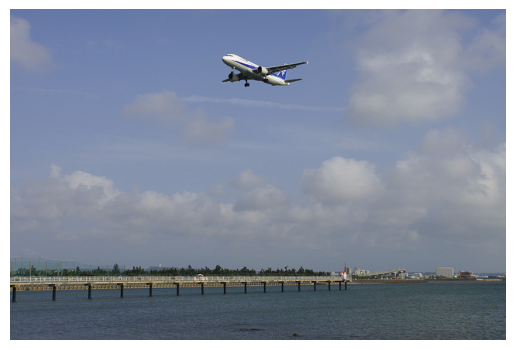

==== Baseline ====
The image depicts a large airplane flying high in the sky over a body of water. The airplane is positioned towards the center of the scene and appears to be ascending into the sky. The water beneath the airplane is calm, creating a serene atmosphere.

In addition to the airplane, there are several birds scattered throughout the scene, flying at various heights and distances from the water. Some of the birds are closer to the water's surface, while others are higher up in the sky. The combination of the airplane, water, and birds creates a dynamic and picturesque scene.
Hallucinations: [('bird', 'bird'), ('bird', 'bird'), ('bird', 'bird')]
Correctly detected (recall) objects: [('airplane', 'airplane'), ('airplane', 'airplane'), ('airplane', 'airplane'), ('airplane', 'airplane'), ('airplane', 'airplane')]
Ground truth: ['airplane']
==== Edited ====
The image captures an airplane flying high in the sky above a large body of water. The airplane is positioned towards the 

In [23]:
display_image(image_path)
print("==== Baseline ====")
print(baseline_caption)
display_chair_results(baseline_evals)
print("==== Edited ====")
print(new_caption)
display_chair_results(new_chair_eval)